# DONT FORGET TO MINMAXSCALE RETURNS FAM :)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.metrics import mean_squared_error as mse
from sklearn.svm import SVR
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae

C:\Users\AURIMASSilva\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def impute_0(x):
    if pd.isnull(x):
        return 0.00
    else:
        return x

In [3]:
df = pd.read_csv('ready_returns.csv', header =None) # read BTC return data
df.columns = ['marge', 'returns'] # make columns nicer
df2 = pd.read_csv('sentiment_ready.csv') # read BTC sentiment data
df2.columns  = ['index', 'marge', 'sentiment'] # make columns nicer
df2 = df2.iloc[1:,:] # remove 2013-12-12 entry for sentiment
df3 = pd.merge(df,df2, how='outer', on='marge') # merge sentiment and btc return data
assert len(df) == len(df3)   # check if all dates are on
df3 = df3[['marge', 'returns', 'sentiment']] # leave relevant oclumns
df3.columns = ['date', 'returns', 'sentiment'] # change columns
df3['sentiment'] = df3['sentiment'].apply(lambda x : impute_0(x)) # impute missing values with 0

In [4]:
# additional btc price data
df_price = pd.read_csv('lol.csv')
df_price = df_price[1:]
df3['price'] = df_price.values

In [5]:
#df3.to_csv('fourGreta.csv', index = False)

# Prepare data for LSTM consumption

In [6]:
sentiment = df3['sentiment'].values
returns = df3['returns'].values
assert len(sentiment) == len(returns)

In [7]:
sc = MinMaxScaler(feature_range = (-1,1))
sc.fit(returns.reshape(-1,1))
returns = sc.transform(returns.reshape(-1,1))
returns = returns.reshape(1,-1)[0]

In [8]:
data_gen = TimeseriesGenerator(np.append(sentiment,0.00), np.append(sentiment,0.00),
                                       length= 12, sampling_rate=1,
                                       batch_size=1)

# get features and targets from generated batches
features_sentiment = []
targets_sentiment = []
i = 0
while True:
    try:
        features_sentiment.append(list(data_gen[i][0][0]))
        targets_sentiment.append(data_gen[i][1][0])
        i += 1
    except:
        break
data_gen = TimeseriesGenerator(np.append(returns,0.00), np.append(returns,0.00),
                                       length= 12, sampling_rate=1,
                                       batch_size=1)

# get features and targets from generated batches
features_returns = []
targets_returns = []
i = 0
while True:
    try:
        features_returns.append(list(data_gen[i][0][0]))
        targets_returns.append(data_gen[i][1][0])
        i += 1
    except:
        break
        
assert len(features_sentiment) == len(features_returns)
assert len(targets_sentiment) == len(targets_returns)

In [9]:
full_stack = []
for i in range(len(features_sentiment)):
    combined_stack = []
    for ii in range(len(features_sentiment[0])):
        combined_stack.append([features_sentiment[i][ii], features_returns[i][ii]])
    full_stack.append(combined_stack)


In [10]:
features = np.array(full_stack)
targets = np.array(targets_returns)
assert len(targets) == len(features)

---

In [11]:
# get the training, validation and testing sets
x_test, y_test = features[-32:], targets[-32:]
x_hold, y_hold = features[:-32], targets[:-32]



x_train, x_valid = x_hold[:int(len(x_hold)*.9)], x_hold[int(len(x_hold)*.9):]
y_train, y_valid = y_hold[:int(len(y_hold)*.9)], y_hold[int(len(y_hold)*.9):]

assert len(x_train) + len(x_valid) == len(x_hold)
assert len(y_train) + len(y_valid) == len(y_hold)

In [12]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 2)
x_valid = x_valid.reshape(x_valid.shape[0],x_valid.shape[1], 2)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 2)

In [13]:
x_test.shape

(32, 12, 2)

In [14]:
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

In [28]:
model = Sequential()
model.add(GRU(20,input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences= True))
model.add(Dropout(0.5))
model.add(GRU(20))    # return_sequences= True
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'linear'))
print('LSTM Sentiment Model Summary')
model.summary()

LSTM Sentiment Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 12, 20)            1380      
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 20)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 20)                2460      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 3,861
Trainable params: 3,861
Non-trainable params: 0
_________________________________________________________________


In [68]:
# optimizer
optim = Adam(lr = 0.05)

In [69]:
# compiler
model.compile(loss='mse', optimizer=optim, metrics=['mse'])

In [70]:
filepath = "C:\\Users\\AURIMASSilva\\Desktop\\BTC\\memes\\modelsentiment.hdf5"
checkpoint = [
    ModelCheckpoint(filepath, monitor = 'val_mean_squared_error', verbose =1, save_best_only=True, mode= 'min')]
#callbacks_list = [checkpoint]                           



model.fit(x_train, y_train, batch_size = 1, epochs = 5, validation_data =(x_valid, y_valid), verbose = 2, callbacks = checkpoint)

Train on 1361 samples, validate on 152 samples
Epoch 1/5
 - 16s - loss: 0.0927 - mean_squared_error: 0.0927 - val_loss: 0.1648 - val_mean_squared_error: 0.1648

Epoch 00001: val_mean_squared_error improved from inf to 0.16475, saving model to C:\Users\AURIMASSilva\Desktop\BTC\memes\modelsentiment.hdf5
Epoch 2/5
 - 12s - loss: 0.0675 - mean_squared_error: 0.0675 - val_loss: 0.1047 - val_mean_squared_error: 0.1047

Epoch 00002: val_mean_squared_error improved from 0.16475 to 0.10470, saving model to C:\Users\AURIMASSilva\Desktop\BTC\memes\modelsentiment.hdf5
Epoch 3/5
 - 13s - loss: 0.0740 - mean_squared_error: 0.0740 - val_loss: 0.0953 - val_mean_squared_error: 0.0953

Epoch 00003: val_mean_squared_error improved from 0.10470 to 0.09532, saving model to C:\Users\AURIMASSilva\Desktop\BTC\memes\modelsentiment.hdf5
Epoch 4/5
 - 15s - loss: 0.0587 - mean_squared_error: 0.0587 - val_loss: 0.0803 - val_mean_squared_error: 0.0803

Epoch 00004: val_mean_squared_error improved from 0.09532 to 0.

In [71]:
y_hat = model.predict(x_test)
y_test_true = sc.inverse_transform(y_test.reshape(-1,1))
y_hat_true = sc.inverse_transform(y_hat.reshape(-1,1))

In [72]:
np.sqrt(mse(y_test_true, y_hat_true))

4.3968446582036815

In [73]:
mae(y_test_true, y_hat_true)

3.5797025672383205

In [74]:
np.sum(y_test_true - y_hat_true)/len(y_test_true)

0.1390546440969619

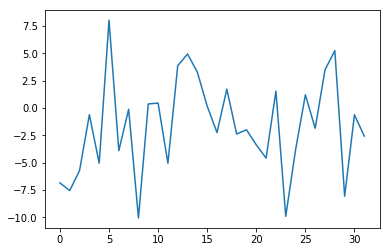

In [75]:
plt.plot(y_test_true)

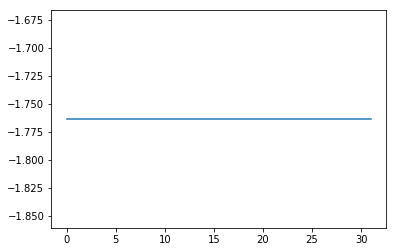

In [76]:
plt.plot(y_hat_true)